## Bloco FENICS com DolfinX

In [2]:
import os
arch = os.getenv("ARGS", "real")

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl
    import dolfinx
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        if arch != "complex":
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        else:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        import ufl
        import dolfinx

import numpy as np
import petsc4py
import petsc4py.PETSc
if arch != "complex":
    assert not np.issubdtype(petsc4py.PETSc.ScalarType, np.complexfloating)
else:
    assert np.issubdtype(petsc4py.PETSc.ScalarType, np.complexfloating)

import importlib.util

if importlib.util.find_spec("petsc4py") is not None:
    import dolfinx

    if not dolfinx.has_petsc:
        print("This demo requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
    from petsc4py.PETSc import ScalarType  # type: ignore
else:
    print("This demo requires petsc4py.")
    exit(0)




## Bloco para o Pyvista

In [3]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import pyvista
else:
    !wget "https://fem-on-colab.github.io/releases/vtk-install.sh" -O "/tmp/vtk-install.sh" && bash "/tmp/vtk-install.sh"
    import pyvista
import panel as pn
import pyvista
import pyvista.examples
pn.extension("vtk")

--2024-11-05 14:02:01--  https://fem-on-colab.github.io/releases/vtk-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1699 (1.7K) [application/x-sh]
Saving to: ‘/tmp/vtk-install.sh’

/tmp/vtk-install.sh 100%[===================>]   1.66K  --.-KB/s    in 0s      

2024-11-05 14:02:01 (20.8 MB/s) - ‘/tmp/vtk-install.sh’ saved [1699/1699]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ VTK_INSTALLED=/usr/local/share/fem-on-colab/vtk.installed
+ [[ ! -f /usr/local/share/fem-on-colab/vtk.installed ]]



    !pip install jupyter_bokeh

and try again.
  pn.extension("vtk")



## Modelo em Fenics para o problema de Poisson

In [6]:
import numpy as np
from mpi4py import MPI

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner

In [26]:
msh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0.0, 0.0), (2.0, 1.0)),
    n=(32, 16),
    cell_type=mesh.CellType.triangle,
)
V = fem.functionspace(msh, ("Lagrange", 1))


facets = mesh.locate_entities_boundary(
    msh,
    dim=(msh.topology.dim - 1),
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], 2.0),
)

dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = 10 * ufl.exp(-((x[0] - 0.5) ** 2 + (x[1] - 0.5) ** 2) / 0.02)
g = ufl.sin(5 * x[0])
a = inner(grad(u), grad(v)) * dx
L = inner(f, v) * dx + inner(g, v) * ds

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()



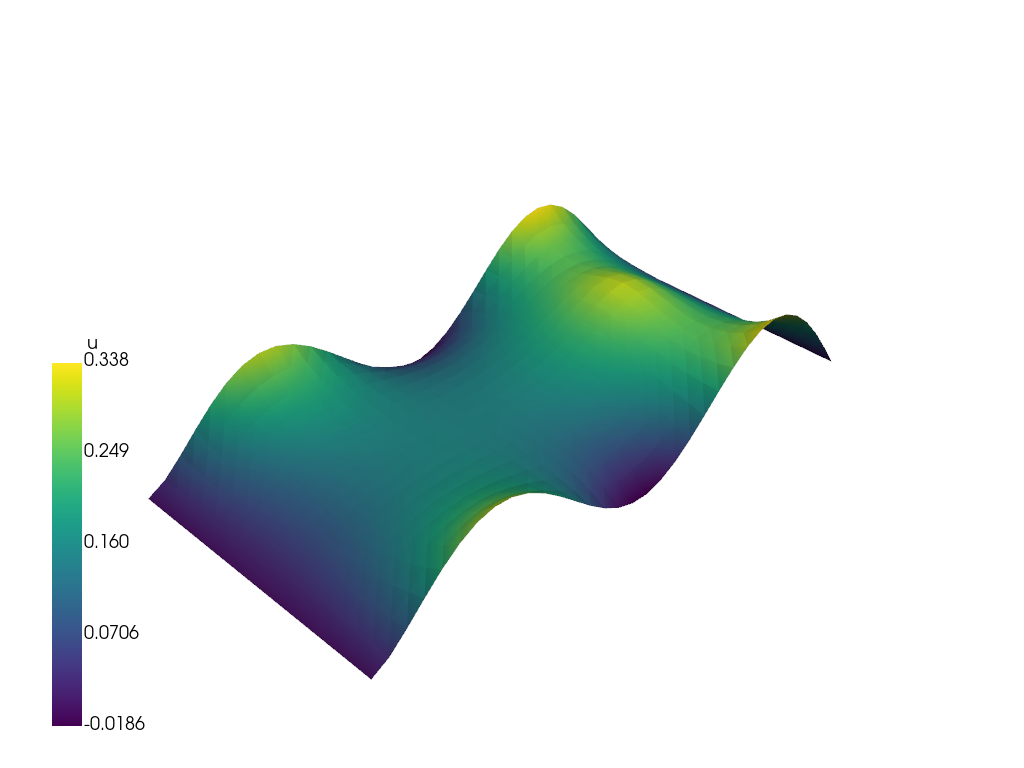

In [27]:
cells, types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter(notebook=True)
#plotter.add_mesh(grid, show_edges=True)
warped = grid.warp_by_scalar()
sargs = dict(height=0.5, vertical=True, position_x=0.05, position_y=0.05)
plotter.add_mesh(warped, scalar_bar_args=sargs)
# Set a custom position and size

#p = pv.Plotter()
#p.add_mesh(mesh, scalar_bar_args=sargs)
#p.show()

# if pyvista.OFF_SCREEN:
#     pyvista.start_xvfb(wait=0.1)
#     plotter.screenshot("uh_poisson.png")
# else:
plotter.show(jupyter_backend="static", return_viewer=True)

## Modelo em Fenics para o problema Bi-harmonico

**Ver Link:** [Biharmonic equation](https://docs.fenicsproject.org/dolfinx/v0.9.0/python/demos/demo_biharmonic.html)

In [ ]:
from mpi4py import MPI

# +
import dolfinx
import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import CellType, GhostMode
from ufl import CellDiameter, FacetNormal, avg, div, dS, dx, grad, inner, jump, pi, sin

In [ ]:
# We begin by using {py:func}`create_rectangle
# <dolfinx.mesh.create_rectangle>` to create a rectangular
# {py:class}`Mesh <dolfinx.mesh.Mesh>` of the domain, and creating a
# finite element {py:class}`FunctionSpace <dolfinx.fem.FunctionSpace>`
# $V$ on the mesh.

msh = mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=((0.0, 0.0), (1.0, 1.0)),
    n=(32, 32),
    cell_type=CellType.triangle,
    ghost_mode=GhostMode.shared_facet,
)
V = fem.functionspace(msh, ("Lagrange", 2))

# The second argument to {py:func}`functionspace
# <dolfinx.fem.functionspace>` is a tuple consisting of `(family,
# degree)`, where `family` is the finite element family, and `degree`
# specifies the polynomial degree. in this case `V` consists of
# second-order, continuous Lagrange finite element functions.
#
# Next, we locate the mesh facets that lie on the boundary
# $\Gamma_D = \partial\Omega$.
# We do this using using {py:func}`exterior_facet_indices
# <dolfinx.mesh.exterior_facet_indices>` which returns all mesh boundary facets
# (Note: if we are only interested in a subset of those, consider {py:func}`locate_entities_boundary
# <dolfinx.mesh.locate_entities_boundary>`).

tdim = msh.topology.dim
msh.topology.create_connectivity(tdim - 1, tdim)
facets = mesh.exterior_facet_indices(msh.topology)

# We now find the degrees-of-freedom that are associated with the
# boundary facets using {py:func}`locate_dofs_topological
# <dolfinx.fem.locate_dofs_topological>`

dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

# and use {py:func}`dirichletbc <dolfinx.fem.dirichletbc>` to create a
# {py:class}`DirichletBC <dolfinx.fem.DirichletBC>`
# class that represents the boundary condition. In this case, we impose
# Dirichlet boundary conditions with value $0$ on the entire boundary
# $\partial\Omega$.

bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

# Next, we express the variational problem using UFL.
#
# First, the penalty parameter $\alpha$ is defined. In addition, we define a
# variable `h` for the cell diameter $h_E$, a variable `n`for the
# outward-facing normal vector $n$ and a variable `h_avg` for the
# average size of cells sharing a facet
# $\left< h \right> = \frac{1}{2} (h_{+} + h_{-})$. Here, the UFL syntax
# `('+')` and `('-')` restricts a function to the `('+')` and `('-')`
# sides of a facet.

alpha = ScalarType(8.0)
h = CellDiameter(msh)
n = FacetNormal(msh)
h_avg = (h("+") + h("-")) / 2.0

# After that, we can define the variational problem consisting of the bilinear
# form $a$ and the linear form $L$. The source term is prescribed as
# $f = 4.0 \pi^4\sin(\pi x)\sin(\pi y)$. Note that with `dS`, integration is
# carried out over all the interior facets $\mathcal{E}_h^{\rm int}$, whereas
# with `ds` it would be only the facets on the boundary of the domain, i.e.
# $\partial\Omega$. The jump operator
# $[\!\![ w ]\!\!] = w_{+} \cdot n_{+} + w_{-} \cdot n_{-}$ w.r.t. the
# outward-facing normal vector $n$ is in UFL available as `jump(w, n)`.

# +
# Define variational problem
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)
f = 4.0 * pi**4 * sin(pi * x[0]) * sin(pi * x[1])

a = (
    inner(div(grad(u)), div(grad(v))) * dx
    - inner(avg(div(grad(u))), jump(grad(v), n)) * dS
    - inner(jump(grad(u), n), avg(div(grad(v)))) * dS
    + alpha / h_avg * inner(jump(grad(u), n), jump(grad(v), n)) * dS
)
L = inner(f, v) * dx
# -

# We create a {py:class}`LinearProblem <dolfinx.fem.petsc.LinearProblem>`
# object that brings together the variational problem, the Dirichlet
# boundary condition, and which specifies the linear solver. In this
# case we use a direct (LU) solver. The {py:func}`solve
# <dolfinx.fem.petsc.LinearProblem.solve>` will compute a solution.

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
#problem = LinearProblem(a, L, bcs=[bc])
uh = problem.solve()

# The solution can be written to a  {py:class}`XDMFFile
# <dolfinx.io.XDMFFile>` file visualization with ParaView or VisIt

# with io.XDMFFile(msh.comm, "out_biharmonic/biharmonic.xdmf", "w") as file:
#     V1 = fem.functionspace(msh, ("Lagrange", 1))
#     u1 = fem.Function(V1)
#     u1.interpolate(uh)
#     file.write_mesh(msh)
#     file.write_function(u1)

# and displayed using [pyvista](https://docs.pyvista.org/).

# +

cells, types, x = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(cells, types, x)
grid.point_data["u"] = uh.x.array.real
grid.set_active_scalars("u")
plotter = pyvista.Plotter(notebook=True)
plotter.add_mesh(grid, show_edges=True)
plotter.add_axes()
warped = grid.warp_by_scalar()
plotter.add_mesh(warped)
# if pyvista.OFF_SCREEN:
# pyvista.start_xvfb()
# html_plotter.screenshot("uh_biharmonic.png")
# else:
plotter.show(jupyter_backend="html", return_viewer=True)


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [ ]:
V

FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 6), Basix element (P, triangle, 2, gll_warped, unset, False, float64, []))